<a href="https://colab.research.google.com/github/srilamaiti/fall_2023_210_capstone_deepika_srila/blob/main/final_deliverable/model/transfer_learning/transfer_learning_with_movinet_5classes_webscraped_recorded_videos_with_chkpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm opencv-python-headless tf-models-official

In [2]:
import os
import tqdm
import random
import pathlib
import itertools
import collections
import shutil
import glob
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pandas as pd
import subprocess
from matplotlib.ticker import MaxNLocator
from datetime import date
from datetime import datetime
from sklearn.metrics import classification_report

import tensorflow as tf
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model
from keras.utils import custom_object_scope
from utils import FrameGenerator
from keras.utils import custom_object_scope
import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

from google.colab import drive
drive.mount("/content/drive", force_remount=True)
os.environ['GDRIVE_CONFIG_DIR'] = "/content/drive/MyDrive"

Mounted at /content/drive


In [3]:
!rm -rf asl
!mkdir asl
!mkdir asl/train asl/val asl/test

def create_dir(dir_path):
    os.makedirs(dir_path, exist_ok=True)

def copy_file(file_name, dir_path):
    !cp {file} {dir_path}

def copy_set_of_files(file_list, dir_path):
    #print(len(file_list), dir_path)
    for file in file_list:
        #print(f"Copying {file} to {dir_path}")
        #copy_file(file_name = file, dir_path = dir_path)
        !cp {file} {dir_path}
    print(f"File count in {dir_path} : {len(os.listdir(dir_path))}")
    #print(os.listdir(dir_path))

def remove_files_from_dir(dir_path):
    for file in os.listdir(dir_path):
        qualified_file_name = os.path.join(dir_path, file)
        !rm -rf {qualified_file_name}
    print(f"File count in {dir_path} : {len(os.listdir(dir_path))}")

def copy_file_from_one_folder_to_folder(src_path, tgt_path):
    src_file_list = glob.glob(src_path + "/*.avi")
    for file in src_file_list:
        #print(file)
        shutil.copy(file, tgt_path)

ROOT_PATH = os.path.join(os.getcwd(), 'asl')
TRAIN_PATH = os.path.join(os.getcwd(), 'asl', 'train')
VAL_PATH = os.path.join(os.getcwd(), 'asl', 'val')
TEST_PATH = os.path.join(os.getcwd(), 'asl', 'test')

DIR_PATH_LIST = [TRAIN_PATH, VAL_PATH, TEST_PATH]
LABEL_LIST = ['hello', 'thankyou', 'teacher', 'class', 'love']
num_classes = len(LABEL_LIST)
print(num_classes)

# Running the code for 5 classes webscraped and recorded videos
label_info_dict = {}
for label in LABEL_LIST:
    label_info_dict[label] = {'remote_train_dir_path'  : os.path.join(os.environ['GDRIVE_CONFIG_DIR'], '5classes_train_val_test_files_recorded_and_webscraped_videos', 'train', label),
                              'remote_val_dir_path'    : os.path.join(os.environ['GDRIVE_CONFIG_DIR'], '5classes_train_val_test_files_recorded_and_webscraped_videos', 'val', label),
                              'remote_test_dir_path'   : os.path.join(os.environ['GDRIVE_CONFIG_DIR'], '5classes_train_val_test_files_recorded_and_webscraped_videos', 'test', label),

                              'local_train_dir_path'  : os.path.join(TRAIN_PATH, label),
                              'local_val_dir_path'    : os.path.join(VAL_PATH, label),
                              'local_test_dir_path'   : os.path.join(TEST_PATH, label)

                             }

asl_path = pathlib.Path('./asl/')

TRAIN_PATH_VAR = asl_path / 'train'
VAL_PATH_VAR = asl_path / 'val'
TEST_PATH_VAR = asl_path / 'test'

subset_paths = {}
subset_paths['train'] = TRAIN_PATH_VAR
subset_paths['val'] = VAL_PATH_VAR
subset_paths['test'] = TEST_PATH_VAR

random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
os.environ['PYTHONHASHSEED'] = '1234'

# Directory structure setup
for dir_path in DIR_PATH_LIST:
    for label in LABEL_LIST:
        temp_dir_path = os.path.join(dir_path, label)
        create_dir(dir_path = temp_dir_path)


# Copy the remote files to local
for label in LABEL_LIST:

    remote_train_dir_path = label_info_dict[label]['remote_train_dir_path']
    remote_val_dir_path = label_info_dict[label]['remote_val_dir_path']
    remote_test_dir_path = label_info_dict[label]['remote_test_dir_path']

    local_train_dir_path = label_info_dict[label]['local_train_dir_path']
    local_val_dir_path = label_info_dict[label]['local_val_dir_path']
    local_test_dir_path = label_info_dict[label]['local_test_dir_path']

    copy_file_from_one_folder_to_folder(src_path = remote_train_dir_path, tgt_path = local_train_dir_path)
    copy_file_from_one_folder_to_folder(src_path = remote_val_dir_path, tgt_path = local_val_dir_path)
    copy_file_from_one_folder_to_folder(src_path = remote_test_dir_path, tgt_path = local_test_dir_path)

5


In [4]:
model_id = 'a1'

In [5]:
!mkdir movinet
!mkdir movinet/a1
!mkdir movinet_a1_checkpoint1
!mkdir movinet_a1_checkpoint1/ckpt_1
!mkdir movinet_a1_asl_recognition

mkdir: cannot create directory ‘movinet’: File exists
mkdir: cannot create directory ‘movinet/a1’: File exists
mkdir: cannot create directory ‘movinet_a1_checkpoint1’: File exists
mkdir: cannot create directory ‘movinet_a1_checkpoint1/ckpt_1’: File exists
mkdir: cannot create directory ‘movinet_a1_asl_recognition’: File exists


In [6]:
batch_size = 8
num_frames = 8
resolution = 224
pre_ckpt_dir = os.path.join(os.getcwd(), f'movinet_{model_id}')
save_ckpt_dir = os.path.join(os.getcwd(), f"movinet_{model_id}_checkpoint1/ckpt_1")
saved_model_dir = os.path.join(os.getcwd(), f"movinet_{model_id}_asl_recognition")
path_save_tflite = 'model_1.tflite'

In [7]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [8]:
for frames, labels in train_ds.take(10):
    print(labels)

print(f"Shape: {frames.shape}")
print(f"Label: {labels.shape}")

tf.Tensor([1 0 2 2 0 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([2 4 4 3 0 3 4 2], shape=(8,), dtype=int16)
tf.Tensor([4 3 3 2 1 4 0 4], shape=(8,), dtype=int16)
tf.Tensor([1 4 0 2 4 2 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 3 3 2 1 4 1 4], shape=(8,), dtype=int16)
tf.Tensor([4 4 4 1 2 1 3 2], shape=(8,), dtype=int16)
tf.Tensor([0 4 0 4 1 2 2 2], shape=(8,), dtype=int16)
tf.Tensor([3 1 4 4 1 0 4 0], shape=(8,), dtype=int16)
tf.Tensor([0 3 4 2 4 1 2 2], shape=(8,), dtype=int16)
tf.Tensor([0 2 1 3 1 3 4 2], shape=(8,), dtype=int16)
Shape: (8, 8, 224, 224, 3)
Label: (8,)


In [9]:
!rm -rf movinet_a1_base.tar.gz movinet_a1_base.tar.gz movinet_a1_base/

In [10]:
tf.keras.backend.clear_session()

backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid'
)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone, num_classes=600)
model.build([1, 1, 1, 1, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a1_stream.tar.gz -O movinet_a1_stream.tar.gz -q
!tar -xvf movinet_a1_stream.tar.gz

checkpoint_dir = f'movinet_{model_id}_stream'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.save(checkpoint_path)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a1_stream/
movinet_a1_stream/ckpt-1.data-00000-of-00001
movinet_a1_stream/ckpt-1.index
movinet_a1_stream/checkpoint


In [11]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, num_frames, resolution, resolution, 3])

  return model

In [12]:
def get_actual_predicted_labels(model, dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [13]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(10, 10)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of ASL recognition for ' + ds_type)
  ax.set_xlabel('Predicted Sign')
  ax.set_ylabel('Actual Sign')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

In [14]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(10, 10)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.tight_layout()
  plt.show(block = False)

In [15]:
fg = FrameGenerator(subset_paths['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())
print(label_names)
print(fg.class_ids_for_name)

['class', 'hello', 'love', 'teacher', 'thankyou']
{'class': 0, 'hello': 1, 'love': 2, 'teacher': 3, 'thankyou': 4}


In [16]:
model_1 = build_classifier(batch_size,
                           num_frames,
                           resolution,
                           backbone,
                           num_classes
                          )

num_epochs = 6
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model_1.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])
# Callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_ckpt_dir,
                                                 save_weights_only=True,
                                                 verbose=1,)

print('Number of Classes: ', num_classes)
print('Total Number of Epochs: ', num_epochs)
print('Batch Size: ', batch_size)

results_1 = model_1.fit(train_ds,
                        validation_data=test_ds,
                        epochs=num_epochs,
                        validation_freq=1,
                        callbacks=[cp_callback],
                        verbose=1)

model_1.evaluate(test_ds, return_dict=True)
print(results_1.history)

Number of Classes:  5
Total Number of Epochs:  6
Batch Size:  8
Epoch 1/6
     60/Unknown - 207s 3s/step - loss: 1.2616 - accuracy: 0.5104
Epoch 1: saving model to /content/movinet_a1_checkpoint1/ckpt_1
60/60 [==============================] - 277s 4s/step - loss: 1.2616 - accuracy: 0.5104 - val_loss: 1.0001 - val_accuracy: 0.6340
Epoch 2/6
60/60 [==============================] - ETA: 0s - loss: 0.6642 - accuracy: 0.7542
Epoch 2: saving model to /content/movinet_a1_checkpoint1/ckpt_1
60/60 [==============================] - 228s 4s/step - loss: 0.6642 - accuracy: 0.7542 - val_loss: 0.7672 - val_accuracy: 0.6667
Epoch 3/6
60/60 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.8646
Epoch 3: saving model to /content/movinet_a1_checkpoint1/ckpt_1
60/60 [==============================] - 228s 4s/step - loss: 0.4171 - accuracy: 0.8646 - val_loss: 0.5947 - val_accuracy: 0.7843
Epoch 4/6
60/60 [==============================] - ETA: 0s - loss: 0.4009 - accuracy: 0.8604


In [17]:
%matplotlib inline

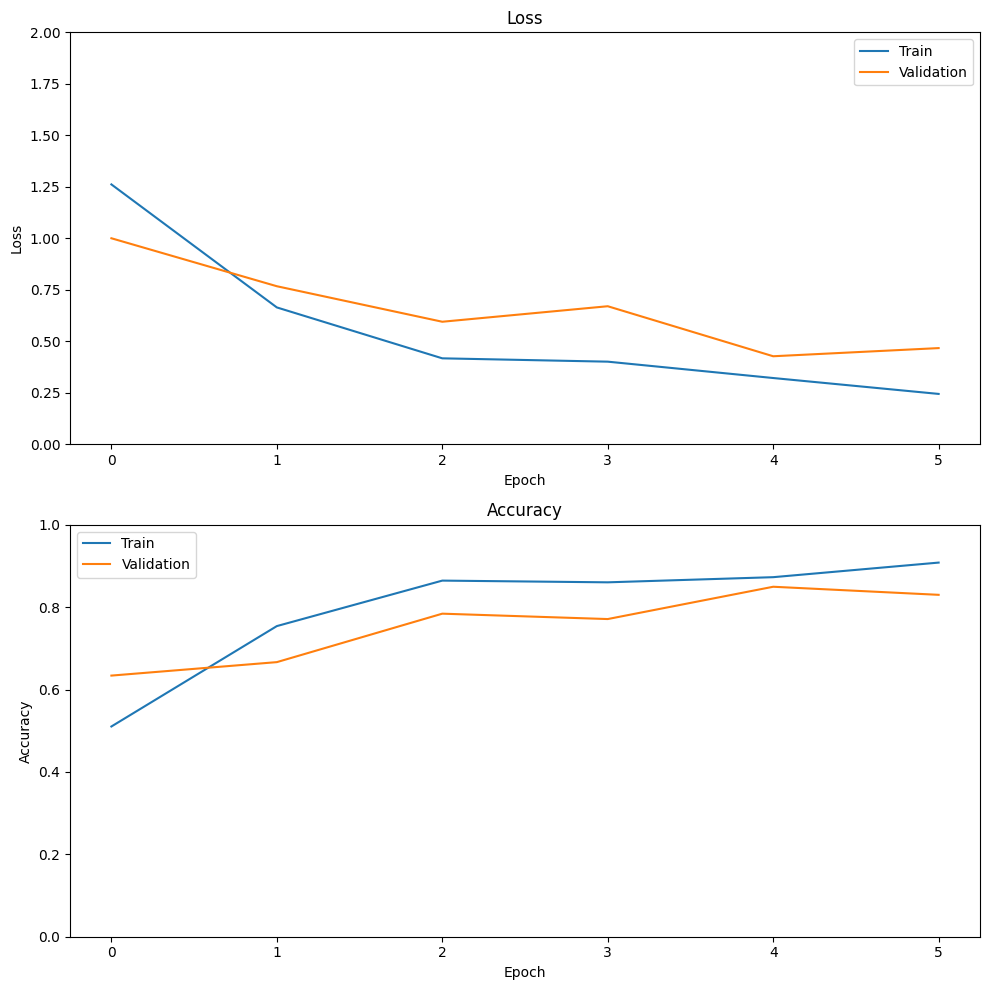

In [18]:
plot_history(results_1)

In [19]:
train_actual_1, train_predicted_1 = get_actual_predicted_labels(model_1, train_ds)
test_actual_1, test_predicted_1 = get_actual_predicted_labels(model_1, test_ds)

20/20 [==============================] - 53s 3s/step


In [20]:
train_actual_1, train_predicted_1

(<tf.Tensor: shape=(480,), dtype=int16, numpy=
 array([0, 2, 4, 3, 4, 3, 3, 0, 0, 0, 1, 4, 2, 4, 3, 4, 4, 1, 0, 0, 3, 2,
        4, 3, 2, 3, 0, 4, 0, 1, 1, 3, 2, 1, 2, 2, 1, 2, 4, 2, 4, 1, 2, 0,
        3, 2, 4, 0, 3, 1, 3, 3, 4, 3, 3, 3, 4, 2, 0, 4, 3, 2, 0, 0, 0, 4,
        1, 0, 3, 1, 1, 4, 3, 4, 3, 2, 0, 4, 3, 2, 3, 4, 4, 2, 0, 1, 1, 3,
        0, 3, 3, 3, 0, 2, 2, 0, 4, 0, 4, 4, 4, 2, 0, 1, 4, 0, 1, 1, 2, 2,
        3, 4, 0, 1, 2, 1, 1, 0, 4, 0, 0, 4, 3, 2, 0, 2, 1, 2, 3, 3, 2, 0,
        4, 2, 2, 1, 2, 4, 3, 3, 4, 1, 3, 2, 4, 1, 2, 3, 1, 0, 3, 3, 4, 3,
        1, 3, 2, 0, 3, 3, 1, 0, 4, 3, 4, 3, 2, 0, 1, 1, 3, 4, 3, 2, 3, 4,
        3, 4, 4, 1, 4, 3, 2, 4, 0, 4, 2, 4, 2, 2, 1, 0, 0, 0, 2, 4, 2, 0,
        0, 2, 0, 0, 2, 3, 0, 0, 1, 2, 3, 0, 1, 4, 0, 1, 1, 4, 4, 2, 0, 4,
        1, 4, 2, 0, 1, 0, 0, 1, 1, 3, 1, 4, 4, 3, 3, 4, 3, 1, 1, 0, 1, 2,
        0, 4, 3, 0, 2, 1, 0, 2, 0, 4, 2, 3, 4, 2, 0, 4, 0, 1, 4, 0, 0, 4,
        1, 0, 0, 1, 0, 3, 3, 2, 0, 1, 2, 3, 3, 0, 3, 3, 1, 3, 0, 

In [21]:
test_actual_1, test_predicted_1

(<tf.Tensor: shape=(153,), dtype=int16, numpy=
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       dtype=int16)>,
 <tf.Tensor: shape=(153,), dtype=int64, numpy=
 array([3, 4, 0, 3, 4, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 4, 0, 4, 3,
        3, 3, 1, 3, 2, 0, 3, 0, 3, 3, 0, 2, 0, 0, 4, 0, 0, 0, 0, 3, 0, 0,
        0, 0, 3, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 3, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4

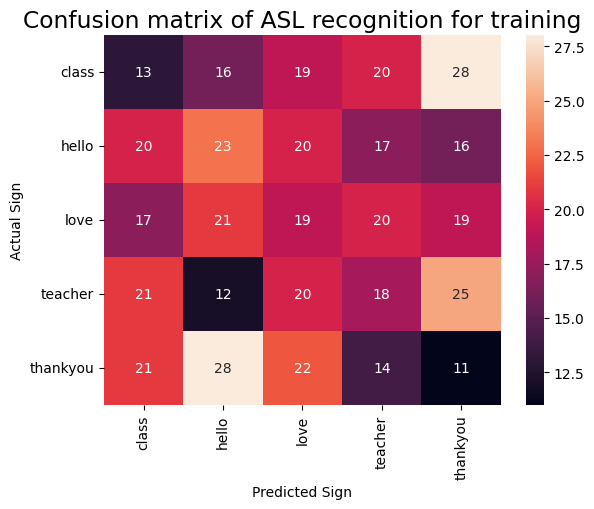

In [22]:
plot_confusion_matrix(train_actual_1, train_predicted_1, label_names, 'training')

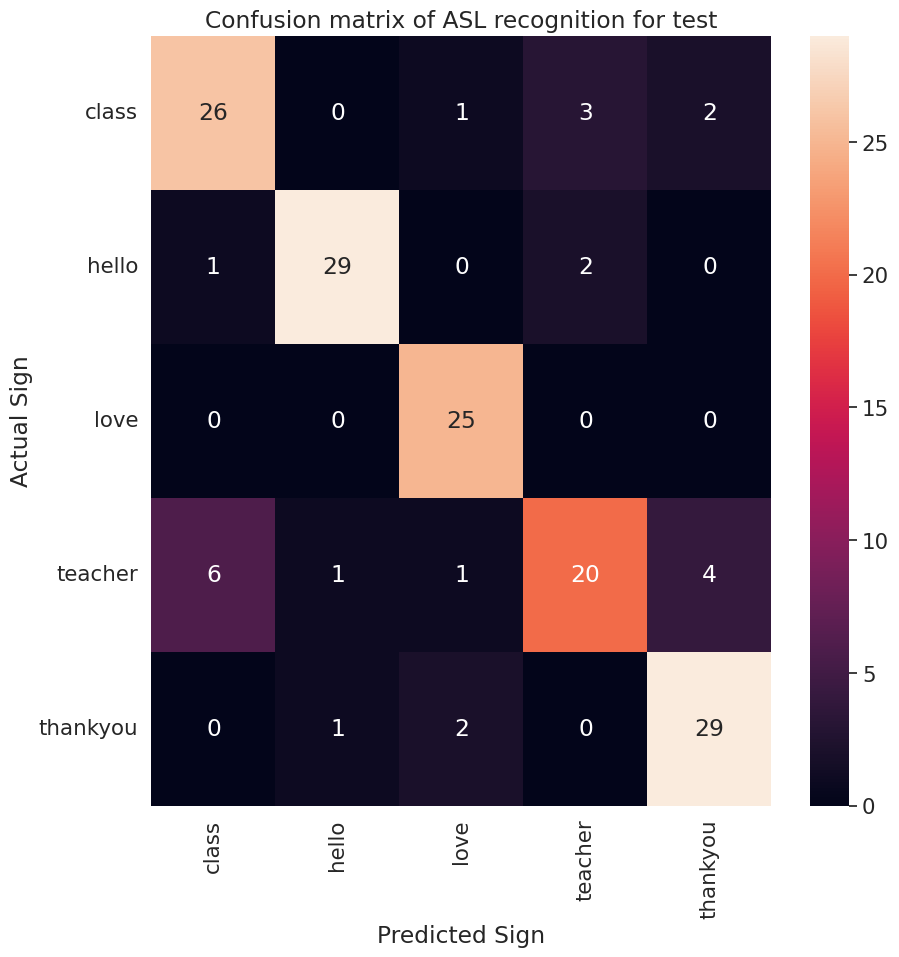

In [23]:
plot_confusion_matrix(test_actual_1, test_predicted_1, label_names, 'test')

In [24]:
print(classification_report(train_actual_1, train_predicted_1))

              precision    recall  f1-score   support

           0       0.14      0.14      0.14        96
           1       0.23      0.24      0.23        96
           2       0.19      0.20      0.19        96
           3       0.20      0.19      0.19        96
           4       0.11      0.11      0.11        96

    accuracy                           0.17       480
   macro avg       0.17      0.17      0.17       480
weighted avg       0.17      0.17      0.17       480



In [25]:
print(classification_report(test_actual_1, test_predicted_1))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.94      0.91      0.92        32
           2       0.86      1.00      0.93        25
           3       0.80      0.62      0.70        32
           4       0.83      0.91      0.87        32

    accuracy                           0.84       153
   macro avg       0.84      0.85      0.84       153
weighted avg       0.84      0.84      0.84       153



In [26]:
weights=model_1.get_weights()
input_shape = [1, 1, resolution, resolution, 3]
batch_size, num_frames, image_size, = input_shape[:3]
tf.keras.backend.clear_session()

# Create the model
input_specs = tf.keras.layers.InputSpec(shape=input_shape)
stream_backbone = movinet.Movinet(
    model_id='a1',
    causal=True,
    input_specs=input_specs,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='swish',
    gating_activation='sigmoid',
    use_external_states=True)
stream_backbone.trainable=False
stream_model = movinet_model.MovinetClassifier(
    backbone=stream_backbone,
    num_classes=num_classes,
    output_states=True)
stream_model.build([1, 1, resolution, resolution, 3])
stream_model.set_weights(weights)
stream_model.get_weights()[0]
model_1.get_weights()[0]

# Export Model
export_saved_model.export_saved_model(
    model=stream_model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)
print(f'[INFO] Exported model: {saved_model_dir}')

# To TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
with open(path_save_tflite, 'wb') as f:
    f.write(tflite_model)
print(f'[INFO] Saved TFLite model to : {path_save_tflite}')

[INFO] Exported model: /content/movinet_a1_asl_recognition
[INFO] Saved TFLite model to : model_1.tflite
